In [ ]:
#import sys
#import os
#sys.path.append(os.path.abspath(".."))
import numpy as np
import pygrit

In [3]:
# Unit Vectors for defining reference frame
i = np.array([1, 0, 0])
j = np.array([0, 1, 0])
k = np.array([0, 0, 1])

In [4]:
# Axial dimensions on Shaft A1
a1 = 9 + 28.75 + 9 # [mm]
b1 = (13.25 - 9) + 24.25 + 30 / 2 # [mm]
zR1 = a1 + b1 # [mm]

In [5]:
# Axial dimension on shaft A2
zR4 = 17 + 18 / 2 # [mm]
a2 = (46 - zR4) + 9.25 # [mm]
b2 = 16 + 25 + 16 # [mm]
c2 = (58.5 - 16) + 35 # [mm]


In [6]:
# Input
motor = pygrit.InputMotor("Motor1", 7.75e3, 2500, k, np.zeros(3))

In [7]:
# Material
shaftMaterial = pygrit.Material('34NiCrMo6', 1050, 950, 520, 0)
R1R4_material = pygrit.Material('Steel', 1060, 950, 0, 335)
R2R3_material = pygrit.Material('Steel', 1950, 1400, 0, 560)

In [8]:
# Gears
# R1
R1 = pygrit.HelicalGear("R1", k, np.array([0, 0, zR1]), 2.5, 18, 20, 20, 7, 30, R1R4_material)

# R2
R2 = pygrit.HelicalGear("R2", k, np.array([0, 0, zR1]), 2.5, 73, -20, 20, 7, 30, R2R3_material)

# R3
R3 = pygrit.HelicalGear("R3", k, np.array([0, 0, 55]), 2.5, 19, -20, 20, 7, 30, R2R3_material)

# R4
R4 = pygrit.HelicalGear("R4", k, np.array([0, 0, zR4]), 2.5, 51, 20, 20, 7, 30, R1R4_material)

In [9]:
# Supports
# A (roller 30203)
A = pygrit.Support("A", "Roller", "Tapered", "30203", "Explorer", 17, 40, 
                   13.25, 23.4e3, 18.6e3, 1.83e3, 15e3, 9, 0.35, 0, 1.7, 
                   0.9, 0, 0, 0, 0, -1, "B2B", np.zeros(3))

# B (roller 30203)
B = pygrit.Support("B", "Pin", "Tapered", "30203", "Explorer", 17, 40, 
                   13.25, 23.4e3, 18.6e3, 1.83e3, 15e3, 9, 0.35, 0, 1.7, 
                   0.9, 0, 0, 0, 0, 1, "B2B", np.array([0, 0, a1]))

# C (roller 30208)
C = pygrit.Support("C", "Roller", "Tapered", "30208", "Explorer", 40, 80, 
                   19.75, 75.8e3, 68e3, 7.65e3, 7e3, 16, 0.37, 0, 1.6, 0.9,
                   0, 0, 0, 0, -1, "B2B", np.array([0, 0, zR4 + a2]))

# D (roller 30208)
D = pygrit.Support("D", "Pin", "Tapered", "30208", "Explorer", 40, 80, 
                   19.75, 75.8e3, 68e3, 7.65e3, 7e3, 16, 0.37, 0, 1.6, 0.9,
                   0, 0, 0, 0, 1, "B2B", np.array([0, 0, zR4 + a2 + b2]))

# F
F = pygrit.Support("", "", "", "", "", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, "",  0)

In [10]:
# Shafts and meshes
# Shaft A1
A1 = pygrit.Shaft("A1", motor, R1, k, shaftMaterial, A, B, np.array([a1, b1, 0]))
R1.omega = A1.getOmegaShaft()
R1.T_tot = A1.getShaftTorque()

# Gear mesh R1 <--> R2
M1 = pygrit.GearMesh(R1, R2, -j, "External")
R2.omega = M1.GetOmegaMesh()
R2.T_tot = pygrit.Torque(M1.GetMeshTorque(), R2.loc)

# Shaft A1'
A1_p = pygrit.Shaft("A1'", R2, R3, -k, shaftMaterial, F, F, 0)
R3.omega = A1_p.getOmegaShaft()
R3.T_tot = A1_p.getShaftTorque()

# Gear mesh R3 <--> R4
M2 = pygrit.GearMesh(R3, R4, j, "External")
R4.omega = M2.GetOmegaMesh()
R4.T_tot = pygrit.Torque(M2.GetMeshTorque(), R4.loc)

# External force
Fout_r = np.abs(np.sum(R4.T_tot.torque)) / 0.1 * j
Fout_a = 0.25 * np.abs(np.sum(Fout_r)) * (-k)
Fout = pygrit.Force(Fout_a + Fout_r, np.array([0, 0, zR4 + a2 + b2 + c2]))
output = pygrit.Component("Output", None, k, Fout.loc*k, Fout, pygrit.Torque(-R4.T_tot.torque, Fout.loc*k), R4.omega)

# Shaft A2
A2 = pygrit.Shaft("A2", R4, output, k, shaftMaterial, C, D, np.array([a2, b2, c2]))

In [11]:
# Forces
R1.calculateForces(M1, A1)
R2.calculateForces(M1, A1_p)
R3.calculateForces(M2, A1_p)
R4.calculateForces(M2, A2)

# Update A1's external forces and torques
A1.updateEFs([motor.F_tot, R1.F_tot])
A1.updateETs([motor.T_tot, R1.T_tot])

# Update A1_p's external forces and torque
A1_p.updateEFs([R2.F_tot, R3.F_tot])
A1_p.updateETs([R2.T_tot, R3.T_tot])

# Update A2's external forces and torques
A2.updateEFs([R4.F_tot, output.F_tot])
A2.updateETs([R4.T_tot, output.T_tot])

In [12]:
# Reaction forces
A1.calculateReactionForces()
A2.calculateReactionForces()

Case 1a
A1 is in equilibrium
Case 2a
A2 is in equilibrium


In [13]:
A.updateReaction(A1)
B.updateReaction(A1)
C.updateReaction(A2)
D.updateReaction(A2)

In [14]:
# Shaft A2: profile for static verification
statProfile = pygrit.ShaftProfile(np.array([34, 35, 35, 30, 30, 35, 35, 40, 40, 34, 34, 32, 32, 27, 27, 32, 32, 31]) / 2, 
                                  np.array([0, 1, 11.9, 12, 39.9, 40, 45.9, 46, 132.9, 133, 158.4, 158.5, 178.4, 178.5, 208.4, 208.5, 222, 223]))
statProfile.AddFillet(1, [2], 45, 18.5)
statProfile.AddFillet(1, [1], 134, 18)
statProfile_refined = statProfile.refineProfile(0.1)
A2.setProfile(statProfile_refined)
A2.profile.CalculateSectionProperties()

In [15]:
# Shaft A2: define sections
# v1
v1 = pygrit.ShaftSection('V1', np.array([0, 0, 26]), 30, 0.8, shaftMaterial)
v1.AppendKf(np.array([1.6, 2]), np.array(["Bending", "Torsion"]))


In [16]:
v1.name, v1.d, v1.Ra, v1.Kf_B, v1.Kf_T

('V1', 30, 0.8, np.float64(1.6), np.float64(2.0))

In [17]:
# v2
v2 = pygrit.ShaftSection('V2', np.array([0, 0, 46]), 40, 0.8, shaftMaterial)
v2.AddNotchSensitivity(1, A2.material.sigma_u)
v2.AddGeometricStressRaiser(1/35, 40/35)

In [18]:
v2.name, v2.d, v2.Ra, v2.Kt_N, v2.Kf_N, v2.Kt_B, v2.Kf_B, v2.Kt_T, v2.Kf_T

('V2',
 40,
 0.8,
 2.2429257006264303,
 2.0955236554577286,
 2.2468380885498562,
 2.0989720623233037,
 1.6212707846089764,
 1.547592539635224)

In [19]:
# v3
v3 = pygrit.ShaftSection('V3', np.array([0, 0, 133]), 40, 0.8, shaftMaterial)
v3.AddNotchSensitivity(1, A2.material.sigma_u)
v3.AddGeometricStressRaiser(1/34, 40/34)

In [20]:
v3.name, v3.d, v3.Ra, v3.Kt_N, v3.Kf_N, v3.Kt_B, v3.Kf_B, v3.Kt_T, v3.Kf_T

('V3',
 40,
 0.8,
 2.315409681034005,
 2.159411557315588,
 2.2557864416572753,
 2.106859205136125,
 1.7409645947913537,
 1.6530915251341751)

In [21]:
userSections = np.array([v1, v2, v3])
A2.addSections(userSections)

In [22]:
# Internal loads
A2.calculateInternalLoads(np.array([i, j, k]))

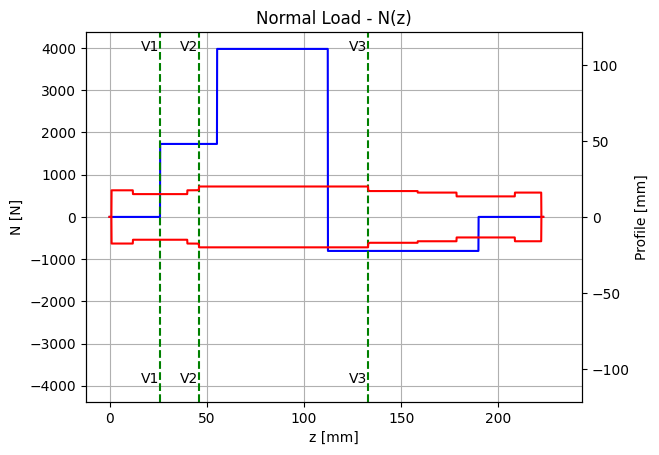

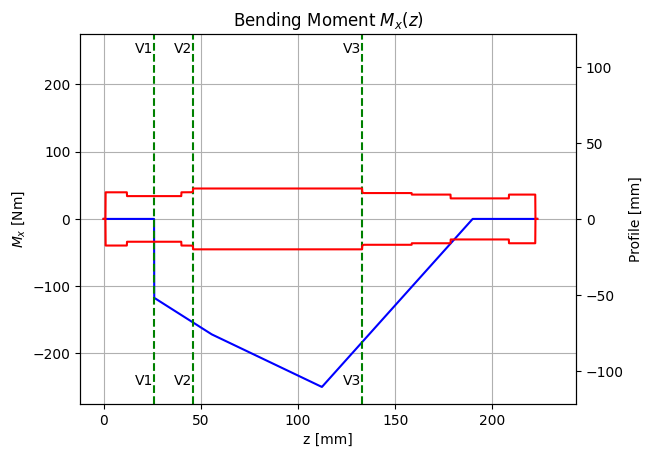

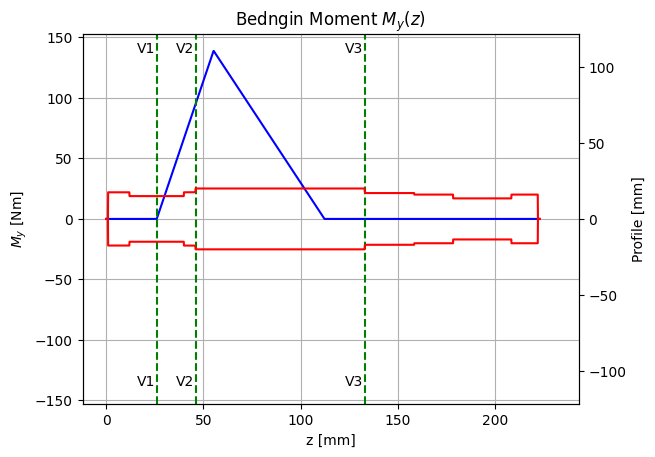

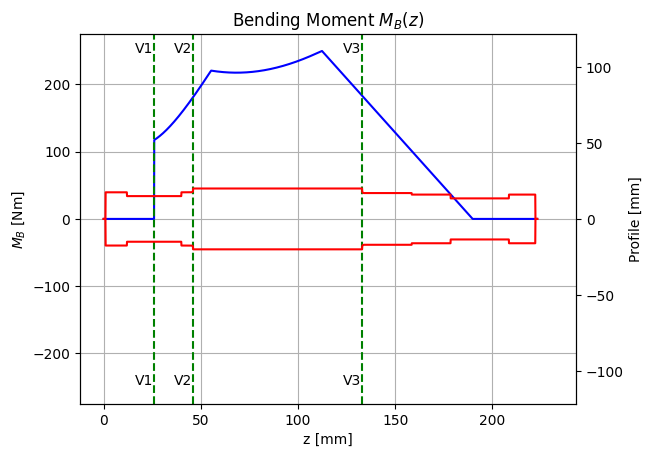

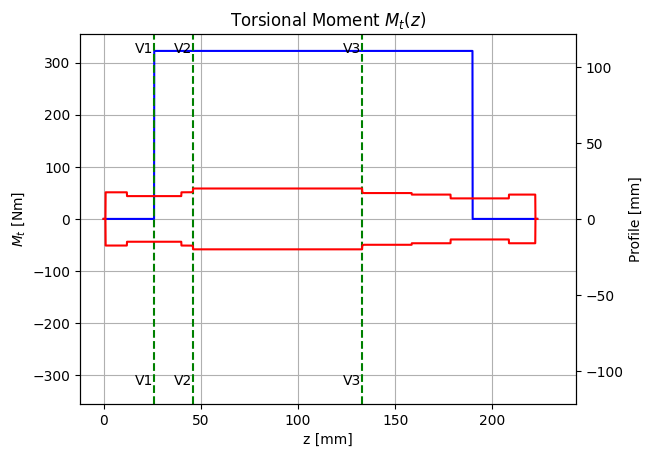

In [23]:
# Plot internal loads
A2.plotInternalLoads()

In [24]:
# Calculate stresses
A2.calculateStresses()
A2.calculateEquivalentAndIdealStress()

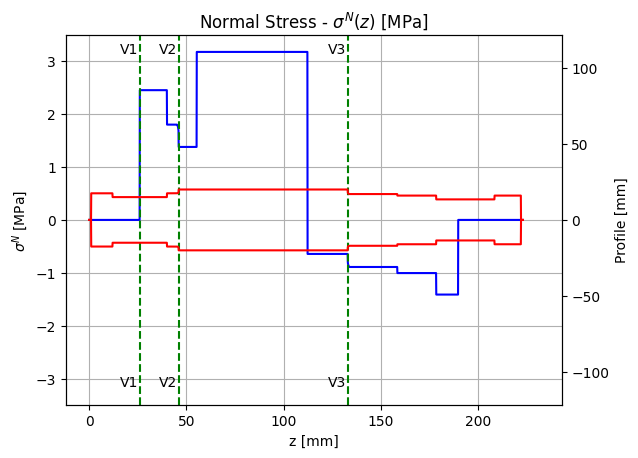

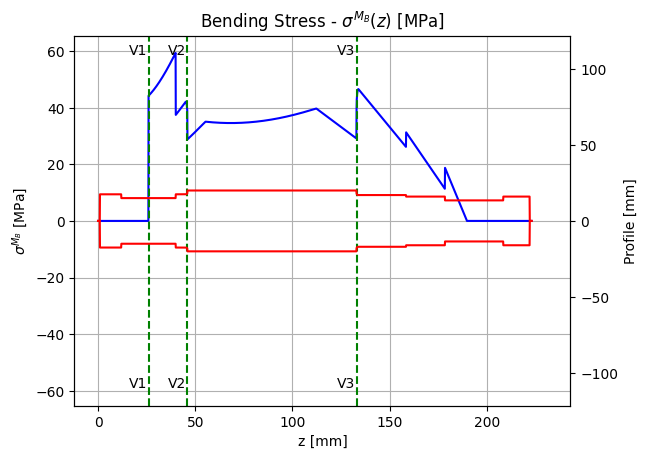

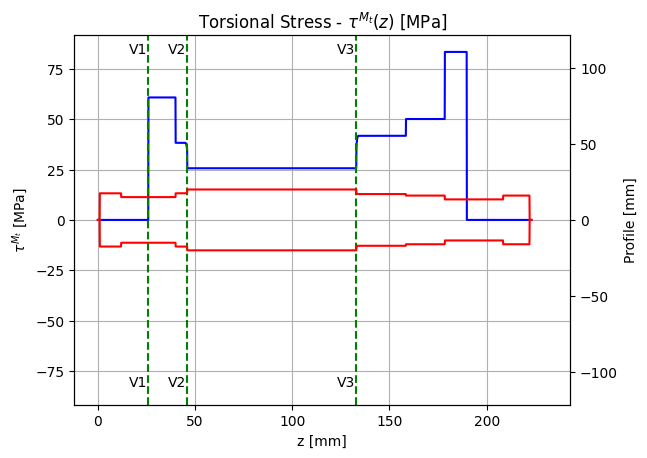

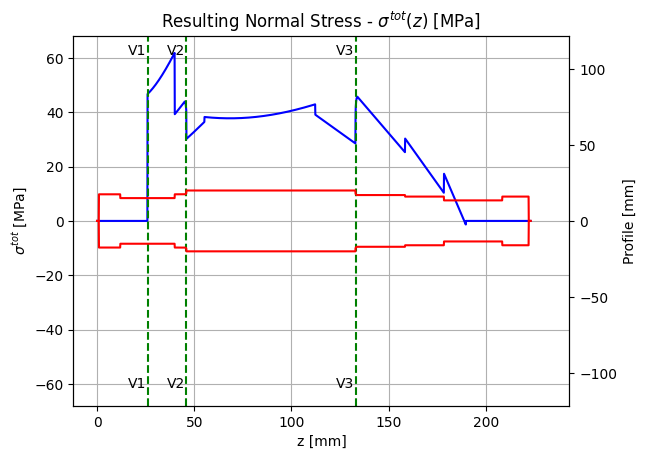

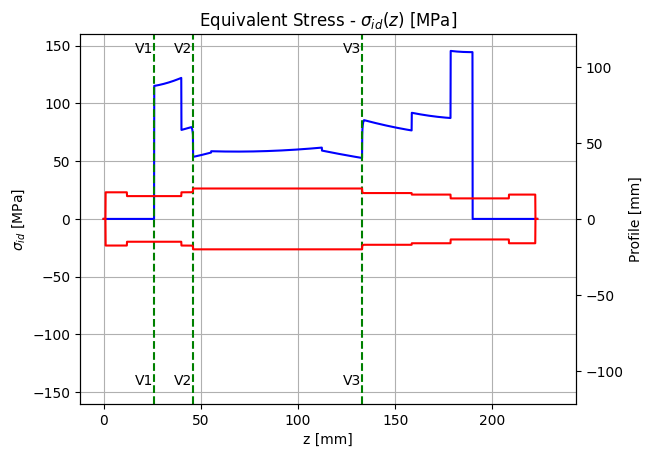

In [25]:
A2.plotStresses()

In [26]:
# Static safety factors
A2.calculateStaticSafetyFactor(sections=userSections)

In [27]:
userSections[2].staticSF

np.float64(13.118921375260895)

In [28]:
# Shaft A2: profile for fatigue verification
fatigueProfile = pygrit.ShaftProfile(np.array([34, 35, 35, 40, 40, 34, 34, 32, 32, 31]) / 2,
                                     np.array([0, 1, 45.9, 46, 132.9, 133, 158.4, 158.5, 222, 223]))
fatigueProfile.AddFillet(1, [2], 45, 18.5)
fatigueProfile.AddFillet(1, [1], 134, 18)
fatigueProfile_refined = fatigueProfile.refineProfile(0.1)
A2.setProfile(fatigueProfile_refined)
A2.profile.CalculateSectionProperties()
A2.sections[0].d = 35
userSections[0].d = 35

In [29]:
# Recalculate internal loads and stresses
A2.calculateInternalLoads(np.array([i, j, k]))
A2.calculateStresses()

In [30]:
# Recalculate total and equivalent stress
A2.calculateEquivalentAndIdealStress()

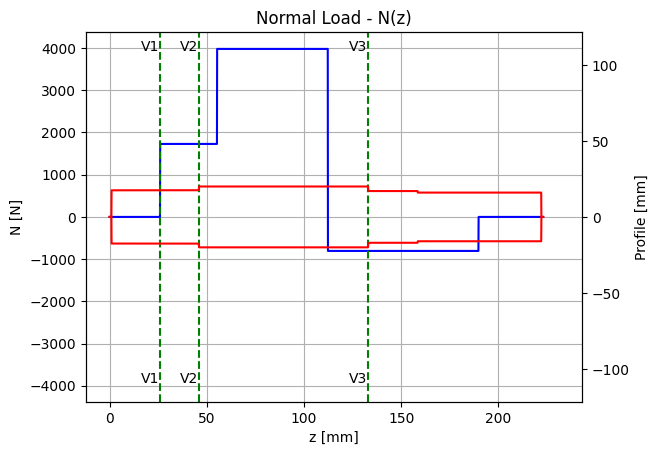

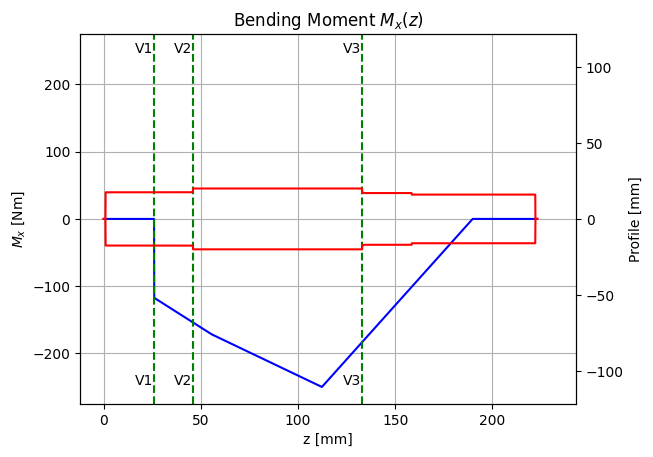

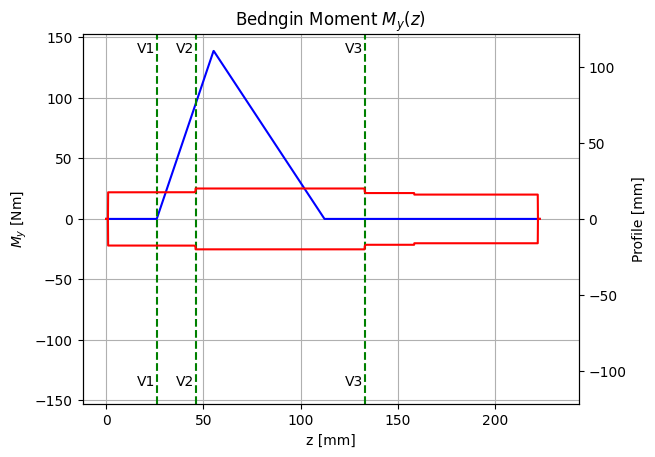

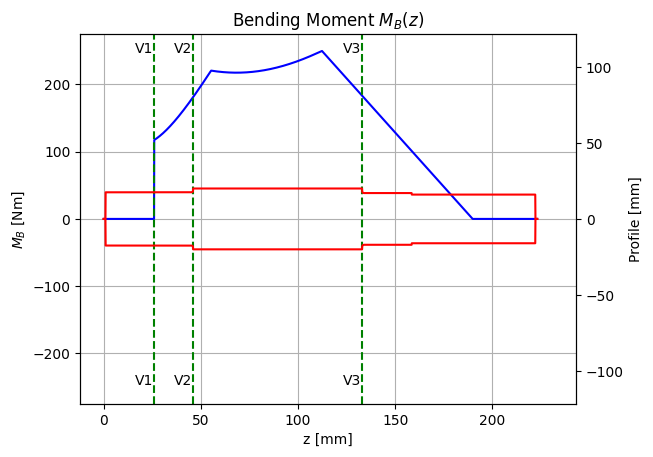

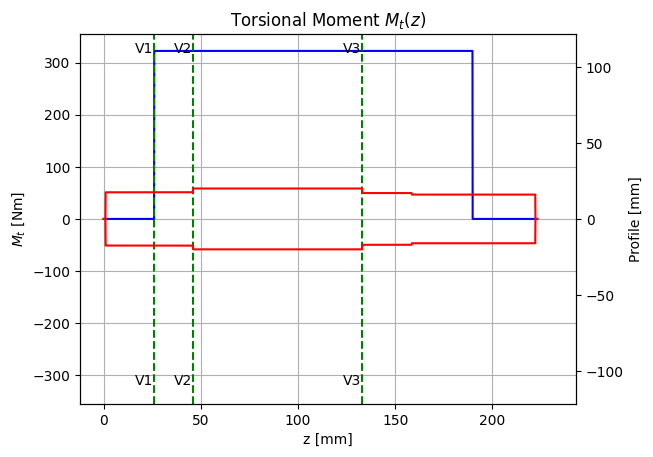

In [31]:
# replot internal loads and stress
A2.plotInternalLoads()

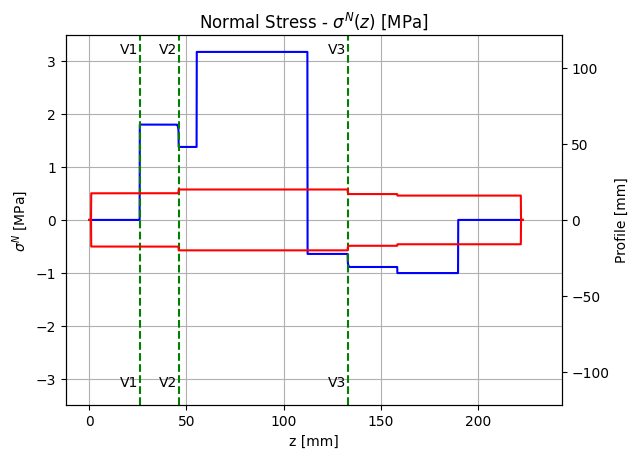

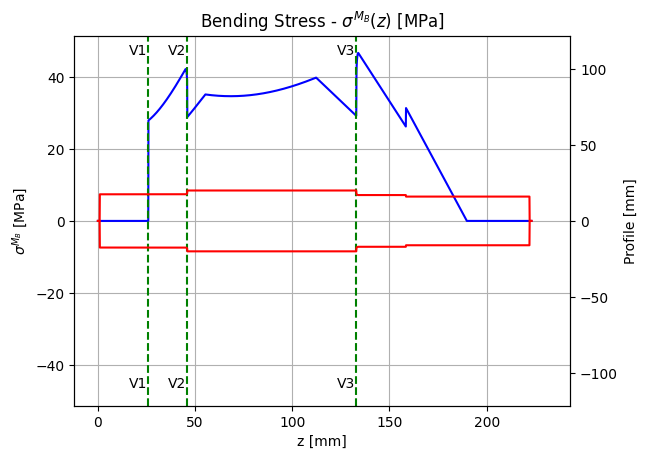

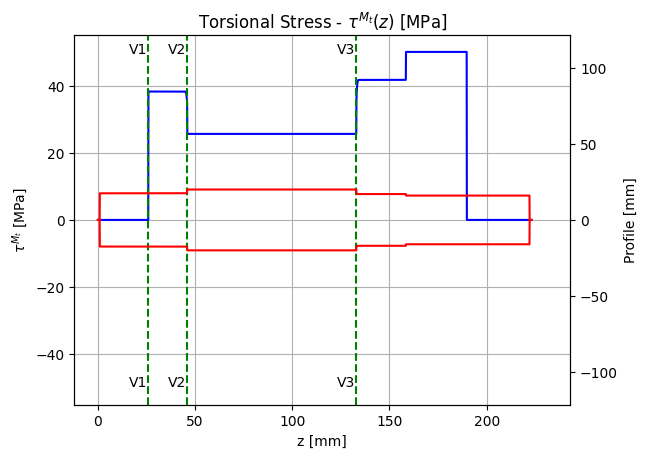

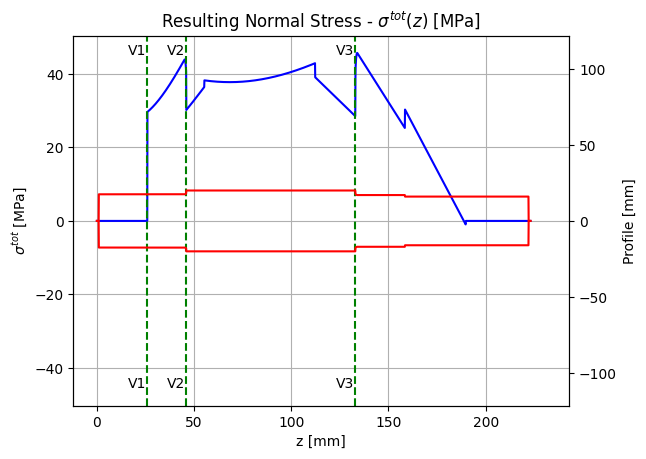

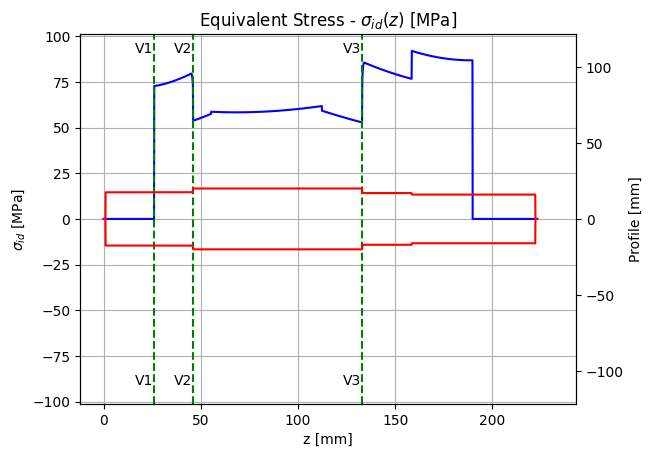

In [32]:
# Replot stresses
A2.plotStresses()

In [33]:
# Calculate mean and alternating stresses
A2.calculateMeanAlternatingStress(userSections)

In [34]:
# Fatigue limit corrector factor
A2.insertFLCF(userSections)

In [35]:
# Equivalent mean and alternating stress
A2.calculateEquivalentStresses(userSections)

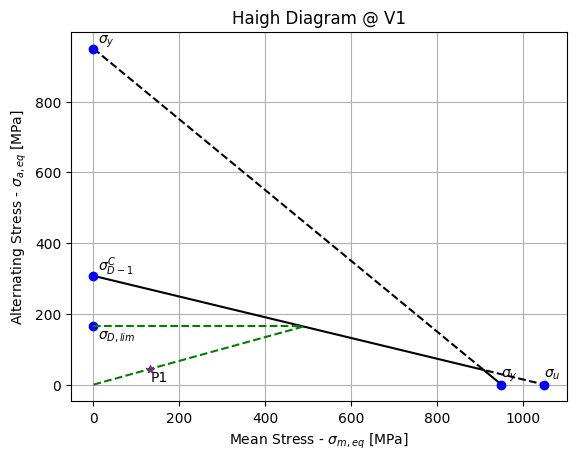

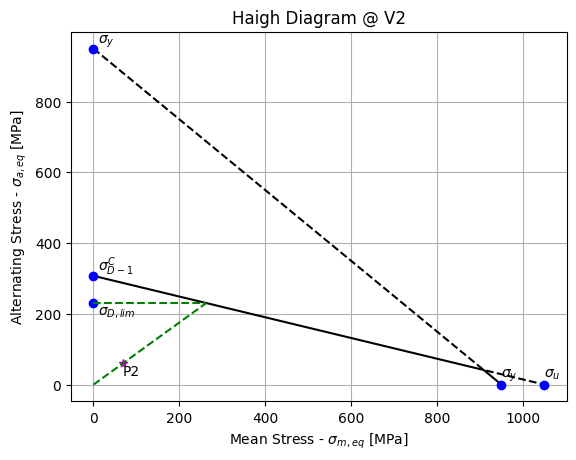

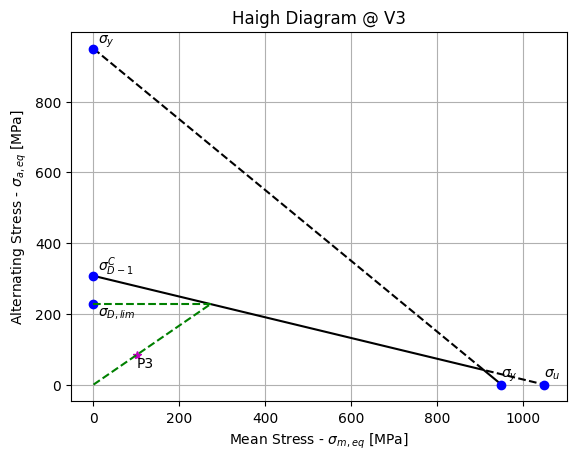

In [36]:
# Plot haigh diagram
for section in userSections:
    section.PlotHaighDiagram()

In [37]:
# Fatigue sagety factor
for section in A2.sections:
    section.CalculateFatigueSF()
    print(f"{section.name}: {section.fatigueSF}")

V1: 3.6865352519994565
V2: 3.8145666519725236
V3: 2.7068698033655907


In [38]:
# Maximum tooth gear bending stress
R1.calculateSigmaMaxFatigue(M1, "Uniform", "Uniform", 35, 1, "uncrowned teeth", a1 + b1 + 50, "Commercial, enclosed units")
R3.calculateSigmaMaxFatigue(M2, "Uniform", "Uniform", 30, 1, "uncrowned teeth", 70, "Commercial, enclosed units")

In [39]:
R1.sigma_max_fatigue, R3.sigma_max_fatigue

(np.float64(122.93816236055356), np.float64(185.15506568310443))

In [40]:
# Bending safety factor
R1.calculateBendingSF(320, 1.3558, -0.0178, 1e8, 60, 0.99)
R3.calculateBendingSF(450, 1.3558, -0.0178, 1e8, 60, 0.99)

I'm here!
I'm here!


In [41]:
R1.bendingSF, R3.bendingSF

(array([2.54248788]), array([2.37395534]))

In [42]:
# Maximum gear contact (pitting resistance) stress
R1.calculateSigmaMaxPitting(M1, 1)
R3.calculateSigmaMaxPitting(M2, 1)

In [43]:
R1.sigma_max_pitting, R3.sigma_max_pitting

(np.float64(373.61822901082445), np.float64(667.3413214250069))

In [44]:
# Wear safety factor
R1.calculateWearSF(860, 1.4488, -0.023, 1e8, M1)
R3.calculateWearSF(1360, 1.4488, -0.023, 1e8, M2)

In [45]:
R1.wearSF, R3.wearSF

(array([2.18312615]), array([1.95473546]))

In [46]:
# Minimum load verifivation
A.calculateMinimumLoad()
B.calculateMinimumLoad()
C.calculateMinimumLoad()
D.calculateMinimumLoad()

A satisfies minimium load condition.
B satisfies minimium load condition.
C satisfies minimium load condition.
D satisfies minimium load condition.


In [47]:
A.Frm, B.Frm, C.Frm, D.Frm

(397.8, 397.8, 1288.6000000000001, 1288.6000000000001)

In [48]:
# Equivalent static load
A.calculateEquivalentStaticLoad()
B.calculateEquivalentStaticLoad()
C.calculateEquivalentStaticLoad()
D.calculateEquivalentStaticLoad()

In [49]:
A.s0, B.s0, C.s0, D.s0

(np.float64(4.115481318903416),
 np.float64(6.5437111033362845),
 np.float64(5.30076651501827),
 np.float64(4.862908520626504))

In [50]:
# Reliability factor
A.calculateA1(95)
B.calculateA1(95)
C.calculateA1(95)
D.calculateA1(95)

In [51]:
A.a1, B.a1, C.a1, D.a1

(np.float64(0.64), np.float64(0.64), np.float64(0.64), np.float64(0.64))

In [52]:
# Define oil of choice
oil = pygrit.Oil("ISO VG 100", 60, 15, 45)

In [53]:
# Bearing equivalent dynamic load
A.calculateEquivalentDynamicLoad()
B.calculateEquivalentDynamicLoad()
C.calculateEquivalentDynamicLoad()
D.calculateEquivalentDynamicLoad()

In [54]:
A.P, B.P, C.P, D.P

(np.float64(3456.5851267238672),
 np.float64(2184.479352403692),
 np.float64(10802.653673141656),
 np.float64(6483.342886497884))

In [55]:
# Contamination factor
A.calculateEtaC("Slight contamination")
B.calculateEtaC("Slight contamination")
C.calculateEtaC("Slight contamination")
D.calculateEtaC("Slight contamination")

In [56]:
A.eta_c, B.eta_c, C.eta_c, D.eta_c

(0.4, 0.4, 0.4, 0.4)

In [57]:
# Lubrication, contamination, and fatigue limit factor
A.a_skf = 2
B.a_skf = 5
C.a_skf = 1
D.a_skf = 2

In [58]:
# Calculate bearing life
A.calculateBearingLife()
B.calculateBearingLife()
C.calculateBearingLife()
D.calculateBearingLife()

In [59]:
A.L_10m, A.L_10mh, B.L_10m, B.L_10mh, C.L_10m, C.L_10mh, D.L_10m, D.L_10mh

(np.float64(751.2283539853148),
 array([5008.18902657]),
 np.float64(8670.477639757886),
 array([57803.18426505]),
 np.float64(423.29436052081985),
 array([30719.78370797]),
 np.float64(4642.771952749868),
 array([336940.35048904]))